<h1>Sentiment Analysis - Multiclass Classification </h1>

<h2> I. Introduction & Problem Statement</h2>
<p>Sentiment analysis lies at the heart of modern NLP (Natural Language Processing), empowering organizations to decipher the emotional undercurrents of social media posts, reviews, and user comments in real time. In today’s fast-paced digital landscape, brand managers and customer experience teams rely on these insights to spot emerging trends, defuse potential crises, and tailor offerings to what truly resonates with their audience. This project tackles exactly that challenge by classifying social media text into 3 distinct sentiment categories (positive, neutral, and negative), providing brand managers and customer-experience leaders with the clear, actionable insights they need to guide outreach, crisis response, and product improvements. Through a step-by-step exploration of NLP preprocessing, feature engineering, and model building, this notebook not only equips you with practical machine-learning skills but also serves as an engaging playground for anyone eager to master real-world sentiment analysis techniques.</p>

<h2> II. Data Acquisition </h2>
<p>We acquired the dataset from the <strong>Hugging Face Datasets</strong> repository, which offers a curated collection of annotated social media posts and reviews. Using the Hugging Face Python API, we load the <strong>train</strong>, <strong>val</strong> and <strong>test</strong> splits (in .csv format) directly into our pipeline, streamlining data ingestion while preserving the original partitioning. All records have been anonymized to remove personally identifiable information and adhere to the source platforms’ usage policies, allowing us to focus on feature engineering and model development without privacy or compliance concerns.</p>

<h4> a) Import libraries </h4>

In [4]:
# General libraries
import pandas as pd
import numpy as np
import re
import joblib

# Plots and visuals
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, roc_curve, 
                            auc, precision_recall_curve, average_precision_score, 
                            confusion_matrix, log_loss)

# Machine Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# NLTK for NLP tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Uncomment lines below if stopwords and punkt were not downloaded yet
# nltk.download('stopwords')
# nltk.download('punkt')
stop_words = set(stopwords.words('english'))

<h4> b) Load dataset </h4>

In [5]:
# Get the datasets from hugging face
splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}

train = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])
test = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["test"])

In [6]:
# Checking on the sets
train.head()

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [7]:
# Dataset information
print("Dataset shape:\nTrain:", train.shape, "Val:", val.shape, "Test:", test.shape)

Dataset shape:
Train: (31232, 4) Val: (5205, 4) Test: (5206, 4)


<h2> III. Data Preprocessing </h2>

<h4> a) Cleaning dataset </h4>
<p>Effective text cleaning converts raw inputs into a consistent, model-friendly format by lowercasing all characters, stripping out punctuation and non-alphabetic symbols, and removing common stop words. This process reduces noise and dimensionality, ensuring that only the most meaningful tokens contribute to learning. Handling missing values and normalizing whitespace prevents errors and maintains data integrity, while deduplication guards against overfitting by eliminating redundant examples. Together, these steps streamline feature extraction, accelerate model convergence, and improve the reliability of sentiment predictions.</p>

In [8]:
def clean_text(text):
    # Return empty string if the row in the dataset is empty (or N/A)
    if pd.isna(text):
        return ""

    # Proceed with the cleaning process 
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)                                         # Remove non-alphabet characters
    text = " ".join([word for word in text.split() if word not in stop_words])   # Tokenize and remove stop words
    text = re.sub(r'\s+', ' ', text).strip()                                     # Remove extra spaces
    return text

# Apply the cleaning to all datasets
for df in [train, val, test]:
    df['clean_text'] = df['text'].fillna('').apply(clean_text)
    df.drop_duplicates(subset='clean_text', inplace=True)                        # Remove any duplicates

In [9]:
# Check the result
train.head()

,id,text,label,sentiment,clean_text
0,9536,"Cooking microwave pizzas, yummy",2,positive,cooking microwave pizzas yummy
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral,plans allowing sub tasks show widget
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive,love humor reworded like saying group therapy ...
3,14182,naw idk what ur talkin about,1,neutral,naw idk ur talkin
4,17840,That sucks to hear. I hate days like that,0,negative,sucks hear hate days like


<h4> b) Exploratory Data Analysis (EDA) </h4>
<p>Before diving into model training, it’s essential to explore the data’s underlying patterns and characteristics. Our EDA workflow comprises four key steps—examining class balance, comparing text lengths before and after cleaning, visualizing frequent tokens via word clouds, and leveraging TF-IDF to quantify term relevance and its correlation with sentiment. Together, these analyses inform feature engineering choices and help uncover hidden biases or artifacts.</p>

<h5> 1. Class Distribution </h5>

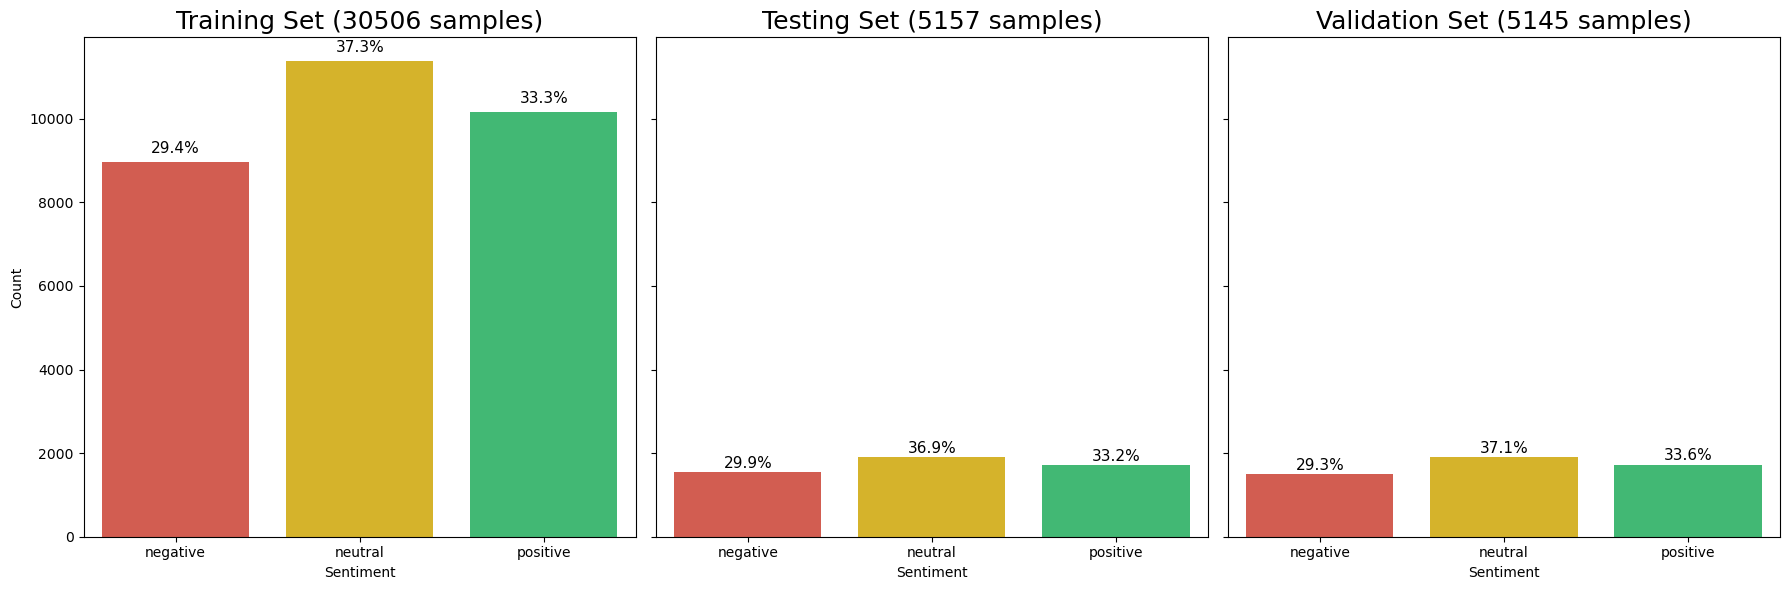

In [10]:
# Define a color map: negative→red, neutral→yellow, positive→green
color_map = {'negative': '#e74c3c','neutral':  '#f1c40f','positive': '#2ecc71'}
sets = [('Training Set', train), ('Testing Set', test), ('Validation Set', val)]

# Create a 1x3 grid to show our plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
categories = ['negative', 'neutral', 'positive']

for ax, (name, df) in zip(axes, sets):
    total = len(df)
    # draw the countplot with hue set to the same variable and no dodging
    sns.countplot(
        data=df,
        x='sentiment',
        hue='sentiment',
        hue_order=categories,
        palette=color_map,
        order=categories,
        dodge=False,
        ax=ax
    )
   
    # Title with dataset size
    ax.set_title(f"{name} ({total} samples)", fontsize=18)
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')

    # Annotate each bar with its percentage
    for p in ax.patches:
        count = p.get_height()
        if count == 0:
            continue
        pct = count / total * 100
        ax.text(
            p.get_x() + p.get_width() / 2,
            count + total * 0.005,
            f"{pct:.1f}%",
            ha='center',
            va='bottom',
            fontsize=11
        )

plt.tight_layout()
plt.show()

<p>From these plots, we see that the training set is composed of roughly 37 % neutral comments, 33 % positive, and 29 % negative—very similar to our test and validation splits. This consistency shows that our partitioning preserved the original sentiment proportions, so our models train and evaluate on representative data. Because neutral examples appear slightly more often during training, the model may learn to recognize neutral sentiments more reliably. In practical terms, its <strong>recall</strong> (the proportion of actual negative examples it correctly catches) could be a bit lower for negatives, and its <strong>precision</strong> (of all the examples the model guesses “negative,” how many truly are negative) might dip slightly. However, since the gap between classes is only about eight percentage points, we expect only a minor effect on overall performance. To be safe, we’ll monitor recall and precision for each sentiment and, if needed, apply class weighting or sampling techniques so that every class gets fair attention during learning.
 </p>

<h5> 2. Text Length (Raw vs Clean text) </h5>

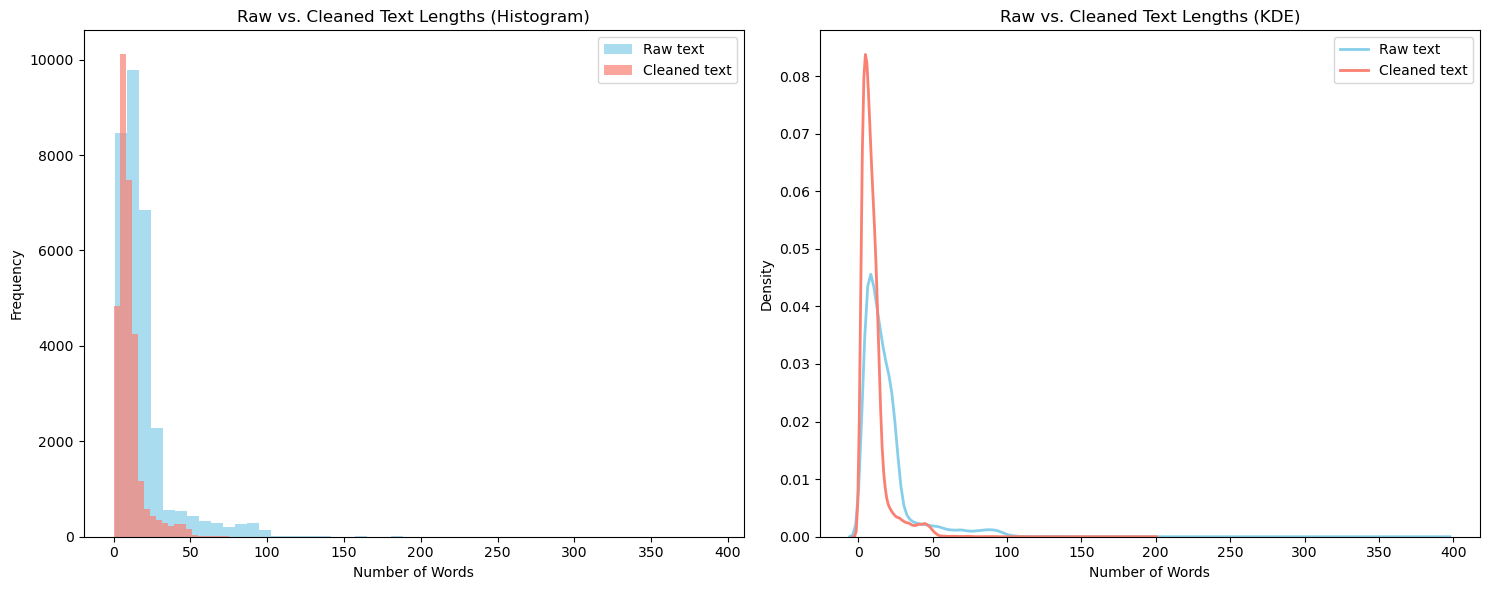

In [11]:
# Compute word counts instead of character lengths
train['raw_word_count']   = train['text'].fillna('').apply(lambda x: len(str(x).split()))
train['clean_word_count'] = train['clean_text'].apply(lambda x: len(str(x).split()))

# Create a 1×2 figure for histograms and KDEs
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=False)

# --- Left: Overlaying histograms of word counts ---
axes[0].hist(train['raw_word_count'],   bins=50, color='skyblue', alpha=0.7, label='Raw text')
axes[0].hist(train['clean_word_count'], bins=50, color='salmon',   alpha=0.7, label='Cleaned text')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Raw vs. Cleaned Text Lengths (Histogram)')
axes[0].legend()

# --- Right: KDE of word counts ---
sns.kdeplot(
    data=train,
    x='raw_word_count',
    label='Raw text',
    ax=axes[1],
    linewidth=2,
    color='skyblue'
)
sns.kdeplot(
    data=train,
    x='clean_word_count',
    label='Cleaned text',
    ax=axes[1],
    linewidth=2,
    color='salmon'
)
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Density')
axes[1].set_title('Raw vs. Cleaned Text Lengths (KDE)')
axes[1].legend()

plt.tight_layout()
plt.show()


<p>In the left‐hand histogram, we see that raw texts most frequently occupy the 15–25 word range, whereas cleaned texts concentrate around 5–15 words—visually highlighting how punctuation removal, stop-word filtering, and whitespace normalization truncate document length. The right-hand KDE reinforces this pattern: the raw‐text density curve has a broader, lower peak and heavier tail, while the cleaned‐text curve is taller and narrower, indicating more consistent word counts with far fewer extreme values. Together, these plots confirm that our cleaning steps both reduce noise and standardize input sizes, speeding up vectorization and model training without sacrificing the core vocabulary needed for sentiment detection.
</p>

<h5> 3. Word Cloud</h5>

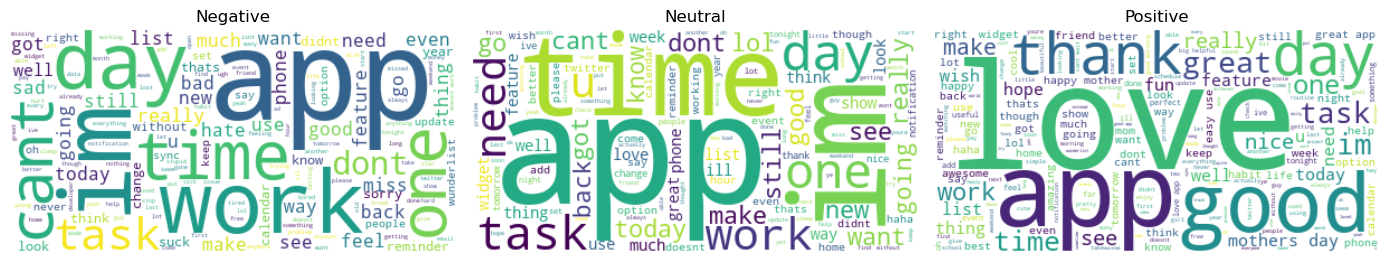

In [12]:
from wordcloud import WordCloud

titles = {0:"Negative", 1:"Neutral", 2:"Positive"}
plt.figure(figsize=(14,4))
for i, lbl in enumerate([0, 1, 2]):
    words = " ".join(train.loc[train['label']==lbl, 'clean_text'])
    wc = WordCloud(width=400, height=200, background_color='white').generate(words)
    plt.subplot(1, 3, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(titles[lbl]); plt.axis('off')
plt.tight_layout(); plt.show()


<p>In the negative word cloud, we see words like “work,” “time,” and “people” alongside more charged terms such as “miss,” “bad,” and “hard,” highlighting frustrations around scheduling, tasks, and interpersonal interactions. The neutral cloud is dominated by functional words such as “time,” “app,” “one,” and “today,” reflecting everyday, non-emotional commentary where users simply describe actions or events. In contrast, the positive cloud features upbeat language like “love,” “great,” “good,” and “fun,” paired with the same context words (“time,” “app,” “work”) but framed in a favorable light. These visualizations reveal which tokens carry the strongest class-specific signals and suggest that combining common context words with their accompanying qualifiers (e.g., “hard” vs. “fun”) will be critical for accurate sentiment discrimination. </p>

<h5> 4. Word-Sentiment Correlation Analysis (Optional/bonus step) </h5>
<p>We want to quantify how individual words relate to overall sentiment by calculating the Pearson correlation between each term’s TF-IDF score and the sentiment polarity. By comparing raw and cleaned text analyses, we identify the strongest positive and negative predictors, guiding feature selection and highlighting the most impactful vocabulary for our sentiment model.</p>

<h6>Quick explanation on Pearson correlation</h6>
<p>Pearson correlation is a statistical measure that quantifies the strength and direction of a linear relationship between two continuous variables, producing a coefficient between –1 and +1. It works by centering each variable around its mean, scaling by its standard deviation, multiplying the paired, normalized values, and then averaging those products. A coefficient close to +1 indicates that the two variables tend to increase together in direct proportion, while a coefficient near –1 signifies that one variable tends to decrease as the other increases. A value around 0 implies no consistent linear trend. Because the calculation normalizes for each variable’s spread, Pearson correlation isolates the pure linear association, regardless of the original units or scales.</p>

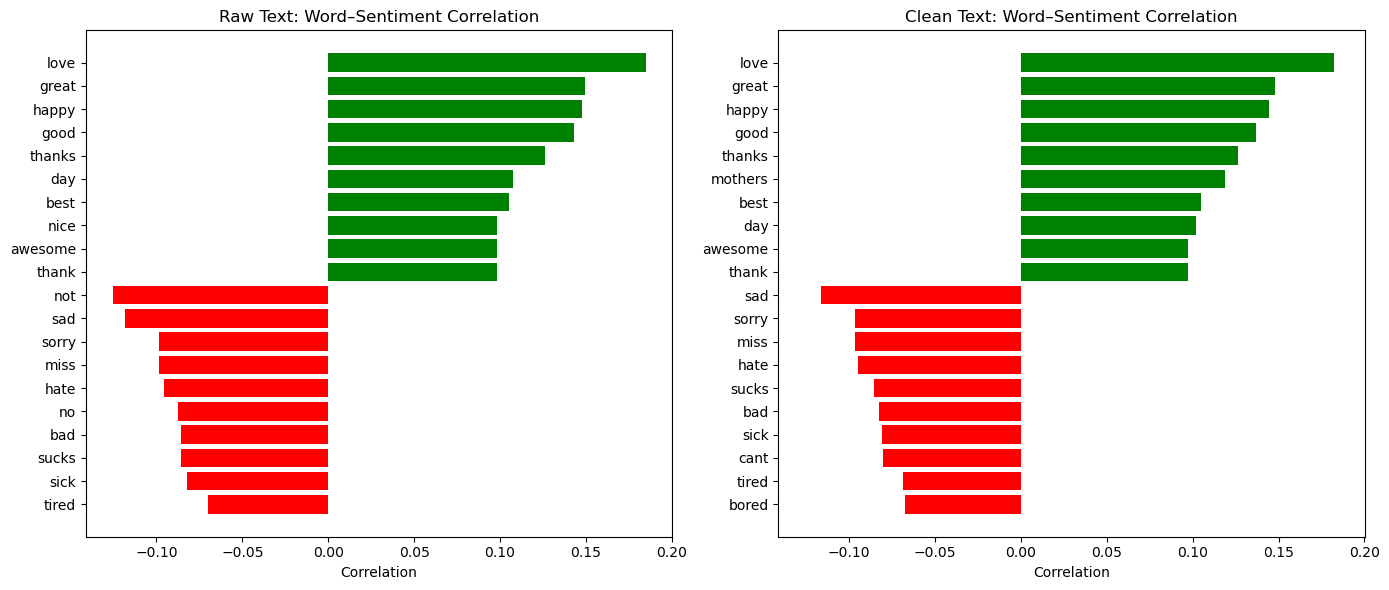

In [13]:
# Convert sentiment into numerical polarity score (-1, 0, 1)
polarity = train['sentiment'].map({"negative": -1, "neutral": 0, "positive": 1}).values

# Create the TF-IDF vectorizer for raw text
vec_raw = TfidfVectorizer(max_features=5000)
X_raw   = vec_raw.fit_transform(train['text'].fillna("")).toarray()
words_raw = np.array(vec_raw.get_feature_names_out())

# Create the TF-IDF vectorizer for clean text
vec_clean = TfidfVectorizer(max_features=5000)
X_clean   = vec_clean.fit_transform(train['clean_text'].fillna("")).toarray()
words_clean = np.array(vec_clean.get_feature_names_out())

# Compute Pearson correlation between each term's TF-IDF score and sentiment polarity
def compute_corr(X, y):
    Xm = X.mean(axis=0);  Xs = X.std(axis=0)
    ym = y.mean();        ys = y.std()
    Xs[Xs==0] = 1
    return ((X - Xm) * (y.reshape(-1, 1)- ym)).sum(axis=0) / ((len(y) - 1) * Xs * ys)

corr_raw   = compute_corr(X_raw, polarity)
corr_clean = compute_corr(X_clean, polarity)

# Find top positive/negative words from raw and clean texts
def top_pos_neg(corrs, words, k=10):
    pos = np.argsort(corrs)[::-1][:k]
    neg = np.argsort(corrs)[:k]
    return words[np.r_[pos, neg]], corrs[np.r_[pos, neg]]

wr, vr = top_pos_neg(corr_raw, words_raw)                         # For raw text
wc_, vc = top_pos_neg(corr_clean, words_clean)                    # For clean text

# Plot the result
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
colors_r = ['green'] * 10 + ['red'] * 10
colors_c = ['green'] * 10 + ['red'] * 10

axes[0].barh(wr[::-1], vr[::-1], color=colors_r[::-1])
axes[0].set_title("Raw Text: Word–Sentiment Correlation"); axes[0].set_xlabel("Correlation")
axes[1].barh(wc_[::-1], vc[::-1], color=colors_c[::-1])
axes[1].set_title("Clean Text: Word–Sentiment Correlation"); axes[1].set_xlabel("Correlation")

plt.tight_layout(); plt.show()


<p>The results are intuitive and consistent across both versions. Positive sentiment is driven by words like love, great, happy, good, and thanks, while negative sentiment aligns with terms such as sad, sorry, hate, sucks, and tired. In the cleaned-text analysis, we also see mothers and bored surface as strong predictors. This happens because preprocessing unifies and normalizes tokens—so “Mother’s” becomes “mothers” (highlighting celebratory or thankful posts) and fragments like “bored,” “bored!” or “I’m bored” collapse into the single token “bored,” sharpening its association with dissatisfaction. Focusing on these high-impact words not only streamlines the feature set and enhances interpretability but also ensures our model captures the most sentiment-salient vocabulary.</p>

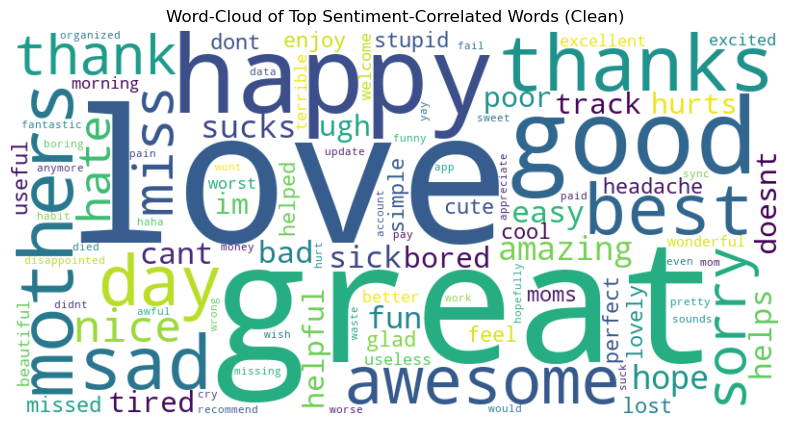

In [14]:
# Build a frequency dictionary from the clean text
corr_dict = {w: abs(c) for w,c in zip(words_clean, corr_clean)}
top100 = dict(sorted(corr_dict.items(), key=lambda x: x[1], reverse=True)[:100])

# Plot the wordcloud
wc = WordCloud(width=800, height=400, background_color='white')\
     .generate_from_frequencies(top100)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word-Cloud of Top Sentiment-Correlated Words (Clean)")
plt.show()

<p> Above is a concise summary of the top sentiment-bearing words and phrases from our training data:

Some tokens like "love" and "good" for positive, "sad" and "hate" for negative, or "helps" and "money" for neutral, directly reflect their respective sentiments. Others, appearing as multi-word expressions (e.g., "happy mothers" and "nice day" for positive, "feel sick" and "awful day" for negative), capture nuanced attitudes with varying strengths. Each of these terms, whether single words or short n-grams, contributes meaningfully to the model’s ability to distinguish between positive and negative sentiment.</p>

<h2> IV. Feature Engineering </h2>
<p>Since our data is now clean, we can turn to feature engineering by creating a dedicated TF-IDF vectorizer for modeling—separate from the one used for visualization. This separation ensures a clear, organized workflow and makes it easy to follow each step of the feature-building process.</p>

In [15]:
# While the clean text is the feature 'X', the sentiment will be our target 'y'
y_train = train['sentiment']
y_val   = val['sentiment']
y_test  = test['sentiment']

# TF-IDF fit on train and vectorize the val and test sets using the clean texts
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train['clean_text'])
X_val_tfidf  = vectorizer.transform(val['clean_text'])
X_test_tfidf = vectorizer.transform(test['clean_text'])

# Compute the class weights (to deal with class imbalance and potentially improve performance)
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, cw))
print("Class weights:", class_weights)

Class weights: {'negative': 1.134389409489811, 'neutral': 0.8936344728593608, 'positive': 1.0005575781429368}


<p><em><strong>Note</strong>: Because our dataset exhibits a mild class imbalance, applying class weights can help improve precision and recall. In fact, our initial unweighted models achieved slightly lower validation metrics (final test‐set results are not presented in this notebook).</em></p>

<h2> V. Modeling & Evaluation </h2>
<p>In this section, we translate our cleaned, TF-IDF vectorized text into predictive models, carefully selecting algorithms that align with the nature of our high-dimensional, sparse input features. Since the task is classification into labels, a few model choices are Logistic Regression, Random Forest, Boosted Tree, and Multi-Layer Perceptron (MLP).</p>

In [16]:
## Helper functions

# Plot the ROC and PR curves
def plot_roc_learning_curve(model, 
                            X_train, y_train, 
                            X_val,   y_val, 
                            classes):
    """
    Left:  ROC curves on the validation set.
    Right: Learning curve (train vs val accuracy) as we grow the training set.
    
    Parameters:
    - model:    any classifier with fit()/predict_proba()/predict()
    - X_train:  full training features (array or sparse)
    - y_train:  full training labels
    - X_val:    validation features
    - y_val:    validation labels
    - classes:  list of the numeric class labels (in the same order as predict_proba)
    """
    # ── ROC panel 
    y_score = model.predict_proba(X_val)
    fig, (ax_roc, ax_lc) = plt.subplots(1, 2, figsize=(14,6))
    
    for idx, cls in enumerate(classes):
        y_true = (y_val == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_true, y_score[:, idx])
        ax_roc.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
    ax_roc.plot([0,1],[0,1],'--',color='gray')
    ax_roc.set_title("ROC Curves (Validation)")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)
    
    # Learning‐curve panel
    n = X_train.shape[0]
    fracs = np.linspace(0.1, 1.0, 10)
    sizes = (fracs * n).astype(int)
    
    train_scores = []
    val_scores   = []
    
    for m in sizes:
        # train on first m examples
        mdl = clone(model)
        mdl.fit(X_train[:m], y_train[:m])
        train_scores.append( accuracy_score(y_train[:m], mdl.predict(X_train[:m])) )
        val_scores.append(   accuracy_score(y_val,    mdl.predict(X_val))        )
    
    ax_lc.plot(sizes, train_scores, 'o-', label='Train')
    ax_lc.plot(sizes, val_scores,   's-', label='Validation')
    ax_lc.set_title("Learning Curve")
    ax_lc.set_xlabel("Training Set Size")
    ax_lc.set_ylabel("Accuracy")
    ax_lc.legend(loc="best")
    ax_lc.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(model, X_val, y_val, X_test, y_test, classes):
    """
    Plots confusion matrices for validation and test sets side by side.

    Parameters:
    - model: a trained classifier with .predict()
    - X_val, X_test: feature matrices
    - y_val, y_test: true labels
    - classes: list of class names in the correct order
    """
    # Generate predictions
    y_val_pred  = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Compute confusion matrices
    cm_val  = confusion_matrix(y_val,  y_val_pred,  labels=classes)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=classes)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title("Validation Set Confusion Matrix")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes, ax=ax2)
    ax2.set_title("Test Set Confusion Matrix")
    ax2.set_xlabel("Predicted")
    # y-axis label only on the first plot

    plt.tight_layout()
    plt.show()


<h4>1. Logistic Regression </h4>
<p>It implements a linear decision boundary on our TF-IDF feaures, making it both fast and highly interpretable. By estimating the probability of each sentiment class through a sigmoid (or softmax for multiclass), it excels when informative wods alone can separate labels without complex interactions. Its simplicity aslo helps identify which terms most strongly influence predictions.</p>

<h5> a) Train and Evaluate</h5>

In [17]:
# Define the model with its parameters
logReg = LogisticRegression(
    max_iter=1000, class_weight=class_weights, random_state=42
)

# Train the model 
logReg.fit(X_train_tfidf, y_train)

# Evaluate the model
y_val_lr = logReg.predict(X_val_tfidf)            # Validation set
y_test_lr = logReg.predict(X_test_tfidf)          # Test set

# Print classification reports
print("★ Validation Accuracy:", round(accuracy_score(y_val, y_val_lr) * 100, 2))
print(classification_report(y_val, y_val_lr, target_names=logReg.classes_))

print("★ Test Accuracy:", round(accuracy_score(y_test, y_test_lr) * 100, 2))
print(classification_report(y_test, y_test_lr, target_names=logReg.classes_))

★ Validation Accuracy: 65.97
              precision    recall  f1-score   support

    negative       0.63      0.68      0.66      1509
     neutral       0.60      0.59      0.60      1909
    positive       0.75      0.71      0.73      1727

    accuracy                           0.66      5145
   macro avg       0.66      0.66      0.66      5145
weighted avg       0.66      0.66      0.66      5145

★ Test Accuracy: 65.85
              precision    recall  f1-score   support

    negative       0.65      0.65      0.65      1541
     neutral       0.60      0.61      0.60      1905
    positive       0.73      0.72      0.73      1711

    accuracy                           0.66      5157
   macro avg       0.66      0.66      0.66      5157
weighted avg       0.66      0.66      0.66      5157



NameError: name 'clone' is not defined

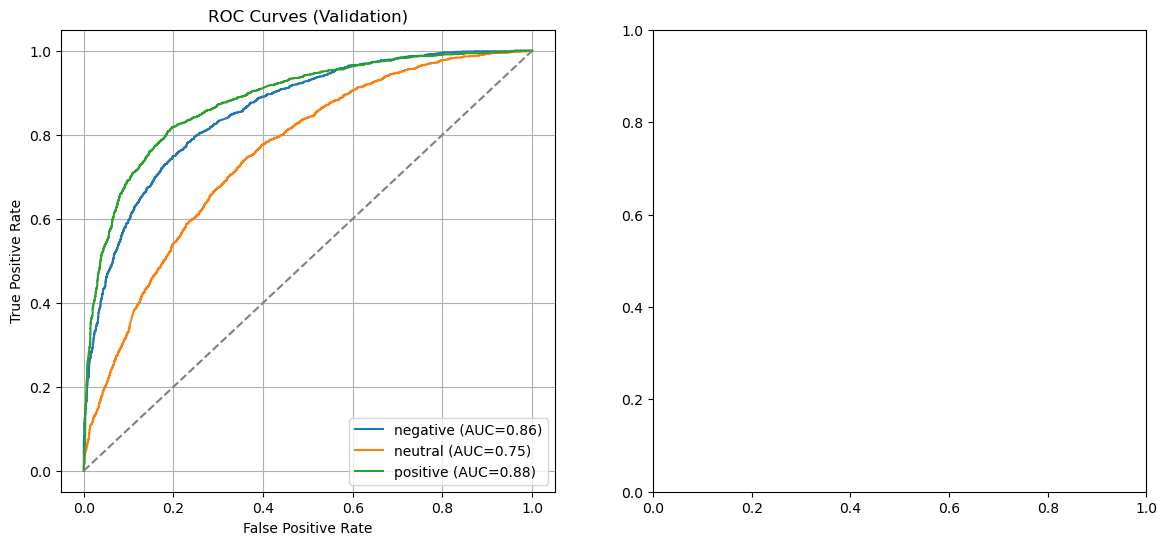

In [18]:
# Show the plot on validation set
plot_roc_learning_curve(logReg, X_train_tfidf, y_train, X_val_tfidf, y_val, logReg.classes_)

# Plot the confusion matrices for both the validation and testing set
plot_confusion_matrices(logReg, X_val_tfidf, y_val, X_test_tfidf, y_test, logReg.classes_)

<h5> b) Discussion </h5>
<p>
    <li>On both validation and test sets, overall accuracy is 66%. For the positive class, precision (~0.74) and recall (~0.72) are highest, yielding F1 ≈ 0.73. The negative class sits in the mid-60s for both metrics, while the neutral class lags at ~0.60 for precision, recall, and F1. These figures confirm consistent strengths on positive sentiment and persistent weaknesses on neutral.</li>
    <li>ROC curves plot true positive rate against false positive rate for each class. With AUCs of 0.88 for positive and 0.86 for negative, the model effectively distinguishes these classes from the rest. However, the neutral class AUC of 0.75 signals weaker separability: the classifier has difficulty differentiating neutral examples from positive or negative, aligning with the confusion‐matrix observations. The further the curve is from the chance line and the more it bows towards the top left (or the y-axis), the better the separability. </li>
    <li>The confusion matrices compare true versus predicted labels on validation and test sets. Both show the model correctly classifies most positives (≈1,230 samples) and negatives (≈1,000 samples), but struggles with neutral instances—many neutrals are mis‐labeled as negative (≈400 samples) or positive(≈320 samples). Importantly, the consistency between validation and test matrices suggests that the model generalizes well, meaning it performs similarly on new data and does not overfit.</li>
</p>

<h5> c) Test</h5>

In [ ]:
# Helper function tailored to show more information after prediction
def predict_with_explanations(text, model, vectorizer, top_n: int = 10):
    # Vectorize
    X = vectorizer.transform([clean_text(text)])
    
    # Predict
    pred_label = model.predict(X)[0]
    proba = model.predict_proba(X)[0]
    class_probs = dict(zip(model.classes_, proba))
    
    # Identify the coefficient row for the predicted class
    #    model.coef_.shape == (n_classes, n_features)
    class_idx = list(model.classes_).index(pred_label)
    coef_for_class = model.coef_[class_idx]
    
    # Compute per-word contributions = tfidf_value * coefficient
    #    X is sparse, so we convert to dense row
    x_dense = X.toarray().ravel()
    contributions = x_dense * coef_for_class
    
    # Get feature names and sort by highest positive contributions
    feature_names = vectorizer.get_feature_names_out()
    top_indices = np.argsort(contributions)[::-1][:top_n]
    top_features = [(feature_names[i], contributions[i]) for i in top_indices if contributions[i] > 0]
    
    return pred_label, class_probs, top_features

In [ ]:
# Playground testing
text = "I found this product very useful for my studies. It made my life easier."
pred, probs, explanation = predict_with_explanations(
    text, model=logReg, vectorizer=vectorizer, top_n=8
)

print("Predicted:", pred)
print("Probabilities:", probs)
print("\nTop contributing words:")
for word, score in explanation:
    print(f"  {word:15s} → {score:.4f}")


In [ ]:
# Save the current model
joblib.dump(logReg, 'lr_model.joblib')

<h4> 2. Random Forest</h4>

In [ ]:
# Build the model using best hyper-parameters 
rf = RandomForestClassifier(
    n_estimators=490, class_weight='balanced', max_features='log2', 
    min_samples_split=3, min_samples_leaf=4
)

# Train the model 
rf.fit(X_train_tfidf, y_train)
y_val_rf = rf.predict(X_val_tfidf)

# Evaluate the model
y_val_rf = rf.predict(X_val_tfidf)            # Validation set
y_test_rf = rf.predict(X_test_tfidf)          # Test set

# Print classification reports
print("★ Validation Accuracy:", round(accuracy_score(y_val, y_val_rf) * 100, 2))
print(classification_report(y_val, y_val_rf, target_names=rf.classes_))

print("★ Test Accuracy:", round(accuracy_score(y_test, y_test_rf) * 100, 2))
print(classification_report(y_test, y_test_rf, target_names=rf.classes_))

In [ ]:
# Show the plot on validation set
plot_roc_learning_curve(rf, X_train_tfidf, y_train, X_val_tfidf, y_val, rf.classes_)

# Plot the confusion matrices for both the validation and testing set
plot_confusion_matrices(rf, X_val_tfidf, y_val, X_test_tfidf, y_test, rf.classes_)

<h5> b) Discussion </h5>
<p>
    <li>The precision, recall, and F₁ scores (validation: macro ≈ 0.67; test: macro ≈ 0.67) confirm reasonably balanced overall performance but lower recall (≈ 0.59–0.60) on neutral examples. Positive sentiment shows the strongest recall (~0.76–0.77) and f₁ (~0.73), whereas neutral remains the weakest. Moreover, almost identical validation and test metrics indicate stability and no major data leakage.</li>
    <li>The ROC curves show that the model discriminates positive (AUC ≈ 0.88) and negative (AUC ≈ 0.86) sentiments very well, while performance on the neutral class trails behind (AUC ≈ 0.75). This tells us the Random Forest is confident distinguishing clear sentiment extremes but struggles to separate neutral cases from the others. </li>
    <li>The learning curve shows that as we increase the training set size, the training accuracy remains steady at around 73–74% while the validation accuracy climbs from 57% to 67%. Because the gap between training and validation scores narrows, we can infer the model is not overfitting and is generalizing better with more data.</li>
    <li>Both validation and test confusion matrices reveal that many neutral samples are misclassified as either negative or positive (e.g., ~350–380 neutral→negative and ~290–360 neutral→positive), while true positives and true negatives have stronger diagonal counts. In particular, neutrality remains the hardest-to-predict label.</li>
</p>

<h5> b) Test </h5>

In [ ]:
# Helper function tailored to show more information after prediction
def predict_with_relevance(text, model, vectorizer, top_n: int = 10):
    # Vectorize
    X = vectorizer.transform([clean_text(text)])
    
    # Predict
    pred_label = model.predict(X)[0]
    proba = model.predict_proba(X)[0]
    class_probs = dict(zip(model.classes_, proba))
    
    # Compute relevance scores = tfidf_value * feature_importance
    x_dense = X.toarray().ravel()
    importances = model.feature_importances_
    relevance = x_dense * importances
    
    # Pick top_n words contributing to the prediction
    feature_names = vectorizer.get_feature_names_out()
    top_idx = np.argsort(relevance)[::-1][:top_n]
    top_features = [(feature_names[i], relevance[i]) for i in top_idx if relevance[i] > 0]
    
    return pred_label, class_probs, top_features

In [ ]:
# Playground testing

text = "The product quality is great, but shipping was painfully slow."
pred, probs, top_feats = predict_with_relevance(
    text, rf, vectorizer, top_n=10
)

print("Predicted label:", pred)
print("Class probabilities:", probs)
print("\nTop contributing words:")
for word, score in top_feats:
    print(f"  {word}: {score:.5f}")

In [ ]:
# Save the model 
joblib.dump(rf, 'rf_model.joblib')

<h4> 3. Boosted Tree </h4>

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.001, 0.03, 0.05, 0.1, 1.0],
    'max_depth': [None, 3, 5],
    'subsample': [0.8, 1.0, 0.2]
}
grid_gbdt = GridSearchCV(
    GradientBoostingClassifier(random_state=42, ),
    param_grid, cv=3, n_jobs=-1, scoring='accuracy'
)
grid_gbdt.fit(X_train_tfidf, y_train)
print("GBDT Best Params:", grid_gbdt.best_params_)
best_gbdt = grid_gbdt.best_estimator_
evaluate("GBDT (tuned)", best_gbdt, X_val_tfidf, y_val, X_test_tfidf, y_test)


In [ ]:
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.metrics    import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Hyperparameter grid ---
param_grid = {
    'learning_rate':    [0.05, 0.1],
    'max_depth':        [3, 5],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

best_score, best_params = 0.0, None

# --- Grid search with early stopping via callback ---
for lr in param_grid['learning_rate']:
    for md in param_grid['max_depth']:
        for ss in param_grid['subsample']:
            for cs in param_grid['colsample_bytree']:
                model = xgb.XGBClassifier(
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    random_state=42,
                    learning_rate=lr,
                    max_depth=md,
                    subsample=ss,
                    colsample_bytree=cs,
                    n_estimators=500  # large upper bound
                )
                model.fit(
                    X_train_tfidf, y_train,
                    eval_set=[(X_val_tfidf, y_val)],
                    verbose=False,
                    callbacks=[EarlyStopping(rounds=20, save_best=True)]
                )
                val_pred = model.predict(X_val_tfidf)
                val_acc  = accuracy_score(y_val, val_pred)
                if val_acc > best_score:
                    best_score  = val_acc
                    best_params = {
                        'learning_rate': lr,
                        'max_depth':     md,
                        'subsample':     ss,
                        'colsample_bytree': cs,
                        'n_estimators':  model.get_booster().best_iteration + 1
                    }

print("Best validation accuracy:", best_score)
print("Best hyperparameters:", best_params)

# --- Retrain best model on train+val, evaluate on test ---
final_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    **best_params
)
# combine train+validation
X_comb = xgb.DMatrix(
    np.vstack((X_train_tfidf.toarray(), X_val_tfidf.toarray())),
    label=np.concatenate([y_train, y_val])
)
# we can fit normally since we tuned n_estimators
final_xgb.fit(
    np.vstack((X_train_tfidf.toarray(), X_val_tfidf.toarray())),
    np.concatenate([y_train, y_val])
)

# Evaluate
for split_name, X_split, y_split in [
    ("Validation", X_val_tfidf, y_val),
    ("Test",       X_test_tfidf, y_test)
]:
    preds = final_xgb.predict(X_split)
    acc   = accuracy_score(y_split, preds)
    print(f"XGBoost (tuned) ▶ {split_name} Acc: {acc:.4f}")
    cm = confusion_matrix(y_split, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Neutral','Positive','Negative'])
    disp.plot(cmap='Oranges')
    plt.title(f"XGBoost (tuned) — {split_name} Confusion Matrix")
    plt.show()


<h2> VII. Conclusion </h2>
<p>To address certain accuracy issues: 
Your logistic regression model generalizes well and excels at detecting clear positive or negative sentiment but struggles with neutral text. To improve neutral-class performance, consider richer text representations (e.g., BERT embeddings), feature augmentation (sentiment lexicons or n-grams), or alternative classifiers (Random Forest, XGBoost). You may also tune class weights, apply targeted resampling (SMOTE), or adjust decision thresholds. I’m ready to help implement any of these enhancements.
</p>